### Lib Imports

In [114]:
import glob
import sys
import heapq
import subprocess
import pickle
import yaml
import random
import gensim
import statistics
import wordcloud
import json
import os.path
import pandas as pd
import numpy as np
from shutil import copytree
from statistics import median
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from copy import deepcopy
from collections import Counter
from tqdm import tqdm
from operator import itemgetter
from pathlib import Path
from IPython.display import clear_output
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
plt.style.use('ggplot')

### Import CSV files

In [ ]:
# Import Code Coverage Data

BASE_PATH = '/home/jovyan/work/code_coverage_data/'
# Number of slashes to skip to get to username in file path
PARTICIPANT_NAME_SPLIT = 6

df_file_coverage_dict_pma = {}
df_file_coverage_dict_wp = {}

i = 0
for csv_file_coverage in glob.glob(f"{BASE_PATH}phpMyAdmin/pma*/files.csv"):
  i += 1
  participant_name = csv_file_coverage.split('/')[PARTICIPANT_NAME_SPLIT]
  df = pd.read_csv(csv_file_coverage, header=None)
  df_file_coverage_dict_pma[participant_name] = df
print(f"Processed {i} coverage files.")

i = 0
for csv_file_coverage in glob.glob(f"{BASE_PATH}WordPress/wp*/files.csv"):
  i += 1
  participant_name = csv_file_coverage.split('/')[PARTICIPANT_NAME_SPLIT]
  df = pd.read_csv(csv_file_coverage, header=None)
  df_file_coverage_dict_wp[participant_name] = df
print(f"Processed {i} coverage files.")

In [ ]:
# Import Line Coverage Data

df_line_coverage_dict_pma = {}
df_line_coverage_dict_wp = {}

i = 0
for csv_line_coverage in glob.glob(f"{BASE_PATH}phpMyAdmin/pma*/lines.csv"):
  i += 1
  participant_name = csv_line_coverage.split('/')[PARTICIPANT_NAME_SPLIT]
  df = pd.read_csv(csv_line_coverage, header=None)
  df_line_coverage_dict_pma[participant_name] = df
print(f"Processed {i} coverage files.")

i = 0
for csv_line_coverage in glob.glob(f"{BASE_PATH}WordPress/wp*/lines.csv"):
  i += 1
  participant_name = csv_line_coverage.split('/')[PARTICIPANT_NAME_SPLIT]
  df = pd.read_csv(csv_line_coverage, header=None)
  df_line_coverage_dict_wp[participant_name] = df
print(f"Processed {i} coverage files.")


In [ ]:
# Sanitize file names: Remove references to files that do not exist in the vanilla/main version of the web applications
def webapp_file_exists(file_name, prefix, webapp_root):
    file_name_mapped = webapp_root + file_name.replace(prefix, '')
    if os.path.exists(file_name_mapped):
        return True
    else:
        return False

In [ ]:
# Remove non-existing files (eg plugins) from file coverage logs
removed_files_dict = {}

for participant in tqdm(df_file_coverage_dict_wp):
    drop_index_list = []
    for i in df_file_coverage_dict_wp[participant][0].index:
        file_name = df_file_coverage_dict_wp[participant][0][i]
        if not webapp_file_exists(file_name, '/var/www/html', 'files/WebApps/WP_Clusters/WordPress'):
            # display(f"Skipping {file_name}.")
            drop_index_list.append(i)
            if participant not in removed_files_dict:
                removed_files_dict[participant] = [file_name]
            else:
                removed_files_dict[participant].append(file_name)
    df_file_coverage_dict_wp[participant][0] = df_file_coverage_dict_wp[participant][0].drop(drop_index_list)
    df_file_coverage_dict_wp[participant].dropna(inplace=True)

In [ ]:
# Remove non-existing file/lines (eg plugins) from line coverage logs
for participant in tqdm(df_line_coverage_dict_wp):
    drop_index_list = []
    for idx, row in df_line_coverage_dict_wp[participant].iterrows():
        if not df_file_coverage_dict_wp[participant][0].str.contains(row[0]).any():
            drop_index_list.append(idx)
    df_line_coverage_dict_wp[participant] = df_line_coverage_dict_wp[participant].drop(drop_index_list)
    df_line_coverage_dict_wp[participant].dropna(inplace=True)

In [ ]:
for p in removed_files_dict:
    removed_files = len(removed_files_dict[p])
    display(f"Removed {removed_files} files from {p}.")

In [2]:
# Serialize data
# Store
# with open('df_line_coverage_dict.pickle', 'wb') as pkl:
#     pickle.dump([df_line_coverage_dict_pma, df_line_coverage_dict_wp], pkl)
# Retrieve
with open('df_line_coverage_dict.pickle', 'rb') as pkl:
    df_line_coverage_dict_pma, df_line_coverage_dict_wp = pickle.load(pkl)

### Add source code features

#### Extract source code features

In [ ]:
# Automate running php to generate NS jsons here
# LIM/src_features.php
# This container should also have PHP

In [ ]:
def import_ns_df(json_path, path_prefix=None):
    with open(json_path, 'r') as f:
        ns_df = pd.read_json(f)
        ns_df = ns_df.transpose().reset_index().rename(columns={'index': 'file_name'})
        if path_prefix is not None:
            ns_df['file_name'] = ns_df['file_name'].apply(lambda S:S.replace(path_prefix, ''))
        return ns_df
def import_func_df(json_path, path_prefix=None):
    with open(json_path, 'r') as f:
        func_json = json.load(f)
        func_df = pd.DataFrame(columns=['file_name', 'function_name', 'start_line', 'end_line'])
        for file_name in tqdm(func_json):
            if len(func_json[file_name]) > 0: # File has functions
                for func_name in func_json[file_name]:
                    if path_prefix is not None:
                        normalized_file_name = file_name.replace(path_prefix, '')
                    else:
                        normalized_file_name = file_name
                    new_row = {'file_name': normalized_file_name, 'function_name': func_name, 'start_line': func_json[file_name][func_name]['start_line'], 'end_line': func_json[file_name][func_name]['end_line']}
                    func_df = func_df.append(new_row, ignore_index=True)
        return func_df

In [ ]:
pma_ns_df = import_ns_df(BASE_PATH + 'LIM/stats/pma/ns_mapping.json', '/home/babak/RBD/rbd_dataanalysis/files/WebApps/PMA_Clusters/phpMyAdmin/')
wp_ns_df = import_ns_df(BASE_PATH + 'LIM/stats/wp/ns_mapping.json', '/home/babak/RBD/rbd_dataanalysis/files/WebApps/WP_Clusters/WordPress/')
mgt_ns_df = import_ns_df(BASE_PATH + 'LIM/stats/mgt/ns_mapping.json', '/home/babak/RBD/rbd_dataanalysis/files/WebApps/MGT_Clusters/magento2/')

In [ ]:
pma_func_df = import_func_df(BASE_PATH + 'LIM/stats/pma/func_mapping.json', '/home/babak/RBD/rbd_dataanalysis/files/WebApps/PMA_Clusters/phpMyAdmin/')
wp_func_df = import_func_df(BASE_PATH + 'LIM/stats/wp/func_mapping.json', '/home/babak/RBD/rbd_dataanalysis/files/WebApps/WP_Clusters/WordPress/')
mgt_func_df = import_func_df(BASE_PATH + 'LIM/stats/mgt/func_mapping.json', '/home/babak/RBD/rbd_dataanalysis/files/WebApps/MGT_Clusters/magento2/')
clear_output(wait=True)

In [4]:
# Serialize data
# Store
# with open('df_src_features.pickle', 'wb') as pkl:
#     pickle.dump([pma_ns_df, wp_ns_df, pma_func_df, wp_func_df], pkl)
# Retrieve
with open('df_src_features.pickle', 'rb') as pkl:
    pma_ns_df, wp_ns_df, _, pma_func_df, wp_func_df, _ = pickle.load(pkl)

#### Map coverage to source code features

In [ ]:
def get_covered_functions_dict(df_line_coverage_dict, func_df):
    covered_functions_dict = {}
    for participant in df_line_coverage_dict:
        covered_functions_dict[participant] = set()
        for index, line_coverage_row in tqdm(df_line_coverage_dict[participant].iterrows(), total=df_line_coverage_dict[participant].shape[0]):
            file_name = line_coverage_row[0].replace('/var/www/html/', '')
            line_number = line_coverage_row[1]
            for index, func_map_row in func_df[func_df['file_name'] == file_name].iterrows():
                if line_number >= func_map_row['start_line'] and line_number <= func_map_row['end_line']:
                    covered_functions_dict[participant].add(func_map_row['function_name'])
                    break
        clear_output(wait=True)
    return covered_functions_dict

def get_covered_ns_dict(df_file_coverage_dict, ns_df):
    covered_ns_dict = {}
    for participant in df_file_coverage_dict:
        covered_ns_dict[participant] = set()
        for index, file_coverage_row in tqdm(df_file_coverage_dict[participant].iterrows(), total=df_file_coverage_dict[participant].shape[0]):
            file_name = file_coverage_row[0].replace('/var/www/html/', '')
            for index, ns_map_row in ns_df[ns_df['file_name'] == file_name].iterrows():
                active_ns = ns_map_row['active_ns']
                if len(active_ns) > 0:
                    covered_ns_dict[participant].add(active_ns[0])
                for used_ns in ns_map_row['used_ns']:
                    covered_ns_dict[participant].add(used_ns)
                break
        clear_output(wait=True)
    return covered_ns_dict

In [ ]:
# Takes 30+ minutes, import from pickle file instead
covered_ns_dict_pma = get_covered_ns_dict(df_file_coverage_dict_pma, pma_ns_df)
covered_ns_dict_wp = get_covered_ns_dict(df_file_coverage_dict_wp, wp_ns_df)

In [5]:
# Serialize data
# Store
# with open('df_covered_ns.pickle', 'wb') as pkl:
#     pickle.dump([covered_ns_dict_pma, covered_ns_dict_wp], pkl)
# Retrieve
with open('df_covered_ns.pickle', 'rb') as pkl:
    covered_ns_dict_pma, covered_ns_dict_wp, _ = pickle.load(pkl)

In [ ]:
# Takes 1 day to run, import from pickle file instead
covered_functions_dict_pma = get_covered_functions_dict(df_line_coverage_dict_pma, pma_func_df)
covered_functions_dict_wp = get_covered_functions_dict(df_line_coverage_dict_wp, wp_func_df)

In [6]:
# Serialize data
# Store
# with open('df_covered_functions.pickle', 'wb') as pkl:
#     pickle.dump([covered_functions_dict_pma, covered_functions_dict_wp], pkl)
# Retrieve
with open('df_covered_functions.pickle', 'rb') as pkl:
    covered_functions_dict_pma, covered_functions_dict_wp, _ = pickle.load(pkl)

## Clustering

### Clustering by NS/Function calls

#### Vectorize

In [ ]:
def merge_features_to_doc(ns_dict, functions_dict, covered_files_dict, participants):
    corpus = []
    for participant in tqdm(participants):
        corpus.append([])
        for index, file in covered_files_dict[participant].iterrows():
            if file[0] is not None:
                file_name = file[0].replace('/var/www/html/', '')
                if file_name not in corpus[-1]:
                    corpus[-1].append(file_name)
        for ns in ns_dict[participant]:
            if ns is not None:
                ns = ns.replace('\\', ' ')
                if ns not in corpus[-1]:
                    corpus[-1].append(ns)
        for func in functions_dict[participant]:
            if func is not None:
                func = func.replace('\\', ' ')
                if func not in corpus[-1]:
                    corpus[-1].append(func)
    for i in range(0, len(corpus)):
        corpus[i] = ' '.join(corpus[i]).replace('/', '')
    return corpus

In [ ]:
corpus_pma = merge_features_to_doc(covered_ns_dict_pma, covered_functions_dict_pma, df_file_coverage_dict_pma, covered_functions_dict_pma.keys())
corpus_wp = merge_features_to_doc(covered_ns_dict_wp, covered_functions_dict_wp, df_file_coverage_dict_wp, covered_functions_dict_wp.keys())

In [ ]:
# Count the number of features
vectorizer = CountVectorizer(binary=True)
ns_func_vectors_pma = vectorizer.fit_transform(corpus_pma)
df_count_ns_func_pma = pd.DataFrame(ns_func_vectors_pma.toarray(),columns=vectorizer.get_feature_names_out())
ns_func_vectors_wp = vectorizer.fit_transform(corpus_wp)
df_count_ns_func_wp = pd.DataFrame(ns_func_vectors_wp.toarray(),columns=vectorizer.get_feature_names_out())

#### Clustering

In [ ]:
def similarity_metric(x, y): # Jaccard similarity (A Intersection B / A Union B)
    matching_coverages = 0
    extra_coverages = 0
    for index in range(0, len(x)):
        if x[index] == 1:
            if x[index] == y[index]:
                matching_coverages += 1
            else:
                extra_coverages += 1
        elif y[index] == 1:
            extra_coverages += 1
    if matching_coverages == 0:
        similarity = 0
    else:
        similarity = matching_coverages / (matching_coverages + extra_coverages)
    return similarity

def get_spectral_models(num_participants, df_tfidf):
    spectral_models = {}
    for i in range(1, num_participants + 1):
        distance_array = pairwise_distances(df_tfidf, metric=similarity_metric)
        current_model = SpectralClustering(n_clusters=i, affinity='precomputed').fit(distance_array)
        spectral_models[i] = current_model
    return spectral_models

def get_spectral_labels(participants, spectral_models):
    df_spectrals = pd.DataFrame()
    df_spectrals['participant'] = participants
    for i in range(1, len(participants) + 1):
        col_name = str(i) + '_clusters'
        df_spectrals[col_name] = spectral_models[i].labels_
    return df_spectrals

In [ ]:
spectral_models_pma = get_spectral_models(len(covered_functions_dict_pma.keys()), df_count_ns_func_pma)
spectral_models_wp = get_spectral_models(len(covered_functions_dict_wp.keys()), df_count_ns_func_wp)

In [ ]:
spectral_models_pma_labels = get_spectral_labels(covered_functions_dict_pma.keys(), spectral_models_pma)
spectral_models_wp_labels = get_spectral_labels(covered_functions_dict_wp.keys(), spectral_models_wp)

In [ ]:
# Print members of each cluster for various cluster sizes
for debloating in spectral_models_pma_labels.columns[1:]:
    display(f"{debloating}: {Counter(spectral_models_pma_labels[debloating]).values()}")

In [ ]:
# Print members of each cluster for various cluster sizes
for debloating in spectral_models_wp_labels.columns[1:]:
    display(f"{debloating}: {Counter(spectral_models_wp_labels[debloating]).values()}")

In [7]:
# Serialize data
# Store
# with open('spectral_v2_models.pickle', 'wb') as pkl:
#     pickle.dump([spectral_models_v2_pma, spectral_models_v2_wp, spectral_models_v2_mgt, spectral_models_v2_pma_labels, spectral_models_v2_wp_labels, spectral_models_v2_mgt_labels], pkl)
# Retrieve
with open('spectral_models.pickle', 'rb') as pkl:
    spectral_models_pma, spectral_models_wp, _, spectral_models_pma_labels, spectral_models_wp_labels, _ = pickle.load(pkl)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SpectralClustering from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


#### Evaluate clusters

In [ ]:
def plot_covered_functions(df_participant_cluster_mapping, function_coverage_dict, selected_clusters=range(1, 21), plot=True):
    avg_functions = []
    for cluster_size in selected_clusters:
        cluster_functions = []
        for cluster_id in range(0, cluster_size):
            users_in_cluster = df_participant_cluster_mapping[df_participant_cluster_mapping[f"{cluster_size}_clusters"] == cluster_id]['participant']
            covered_functions = set()
            for user in users_in_cluster:
                covered_functions |= set(function_coverage_dict[user])
            cluster_functions.append(len(covered_functions))
        avg_function_calls = sum(cluster_functions) / len(cluster_functions)
        avg_functions.append(avg_function_calls)
    if plot == True:
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(range(1, 21), avg_functions)
        ax.set_xticks(range(1, 21))
        ax.spines['bottom'].set_color('0.5')
        ax.spines['left'].set_color('0.5')
        ax.grid(axis='x')
        ax.set_xlabel('Number of roles', fontsize=14)
        ax.set_ylabel('Number of functions', fontsize=14)
        fig.show()
    else:
        display(avg_functions)

#### Spectral

In [ ]:
spectral_models_pma_labels['20_clusters'] = spectral_models_pma_labels['19_clusters']
spectral_models_wp_labels['20_clusters'] = spectral_models_wp_labels['19_clusters']

##### Visuals

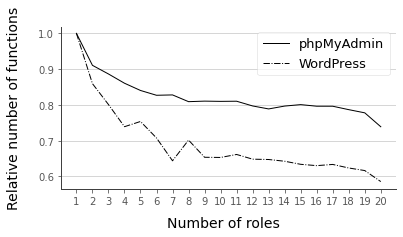

In [127]:
plt.rcParams["font.family"] = "sans"

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3), facecolor='white')

df_participant_cluster_mapping = spectral_models_pma_labels
function_coverage_dict = covered_functions_dict_pma
selected_clusters=range(1, 21)

avg_functions = []
max_size = 0
for cluster_size in selected_clusters:
    cluster_functions = []
    for cluster_id in range(0, cluster_size):
        users_in_cluster = df_participant_cluster_mapping[df_participant_cluster_mapping[f"{cluster_size}_clusters"] == cluster_id]['participant']
        covered_functions = set()
        for user in users_in_cluster:
            covered_functions |= set(function_coverage_dict[user])
        cluster_functions.append(len(covered_functions))
    avg_function_calls = sum(cluster_functions) / len(cluster_functions)
    # avg_function_calls = avg_function_calls * avg_function_calls
    max_size = max([max_size, avg_function_calls])
    avg_functions.append(avg_function_calls / max_size)
ax.plot(range(1, 21), avg_functions, linewidth=1, ls='-', color='black')

df_participant_cluster_mapping = spectral_models_wp_labels
function_coverage_dict = covered_functions_dict_wp
selected_clusters=range(1, 21)

avg_functions = []
max_size = 0
for cluster_size in selected_clusters:
    cluster_functions = []
    for cluster_id in range(0, cluster_size):
        users_in_cluster = df_participant_cluster_mapping[df_participant_cluster_mapping[f"{cluster_size}_clusters"] == cluster_id]['participant']
        covered_functions = set()
        for user in users_in_cluster:
            covered_functions |= set(function_coverage_dict[user])
        cluster_functions.append(len(covered_functions))
    avg_function_calls = sum(cluster_functions) / len(cluster_functions)
    max_size = max([max_size, avg_function_calls])
    avg_functions.append(avg_function_calls / max_size)
ax.plot(range(1, 21), avg_functions, linewidth=1, ls='-.', color='black')
    
ax.set_xticks(range(1, 21))
ax.spines['bottom'].set_color('0.25')
ax.spines['left'].set_color('0.25')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
    
lgd = ax.legend(['phpMyAdmin', 'WordPress', 'Magento'], fontsize=13, facecolor='white', frameon=True, framealpha=0.75)
ax.set_facecolor('white')
fig.text(0.5, -0.05, 'Number of roles', ha='center', fontsize=14)
fig.text(0, 0.5, 'Relative number of functions', va='center', rotation='vertical', fontsize=14)
    
ax.grid(visible=True, axis='y', which='major', color=(0.8, 0.8, 0.8), linestyle='-')
    
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
    
fig.show()

### Optimal Cluster Size

In [82]:
optimal_spectral_cluster_size_pma = 6
optimal_spectral_cluster_size_wp = 7

In [ ]:
display('PMA: ')
plot_covered_functions(spectral_models_pma_labels, covered_functions_dict_pma, [optimal_spectral_cluster_size_pma], False)
display('WP: ')
plot_covered_functions(spectral_models_wp_labels, covered_functions_dict_wp, [optimal_spectral_cluster_size_wp], False)

In [ ]:
kmeans_models_pma = {}
kmeans_models_wp = {}
kmeans_models_mgt = {}

def get_kmeans_models(df_file_coverage_dict, df_tfidf):
  kmeans_models = {}
  for i in range(1, len(df_file_coverage_dict.items()) + 1):
    current_kmean = KMeans(n_clusters=i).fit(df_tfidf)
    kmeans_models[i] = current_kmean
  return kmeans_models

kmeans_models_pma = get_kmeans_models(df_file_coverage_dict_pma, df_tfidf_pma)
kmeans_models_wp = get_kmeans_models(df_file_coverage_dict_wp, df_tfidf_wp)
kmeans_models_mgt = get_kmeans_models(df_file_coverage_dict_mgt, df_tfidf_mgt)

In [ ]:
def get_kmeans_labels(df_file_coverage_dict, kmeans_models):
  df_kmeans = pd.DataFrame()
  df_kmeans['participant'] = [p[0] for p in df_file_coverage_dict.items()]
  for i in range(1, len(df_file_coverage_dict.items()) + 1):
    col_name = str(i) + 'means_label'
    df_kmeans[col_name] = kmeans_models[i].labels_
  return df_kmeans

df_kmeans_pma = get_kmeans_labels(df_file_coverage_dict_pma, kmeans_models_pma)
df_kmeans_wp = get_kmeans_labels(df_file_coverage_dict_wp, kmeans_models_wp)
df_kmeans_mgt = get_kmeans_labels(df_file_coverage_dict_mgt, kmeans_models_mgt)

In [ ]:
# Serialize data
# Store
with open('df_kmeans_fix.pickle', 'wb') as pkl:
    pickle.dump([df_kmeans_pma, df_kmeans_wp, df_kmeans_mgt], pkl)
# Retrieve
# with open('df_kmeans.pickle', 'rb') as pkl:
#     df_kmeans_pma, df_kmeans_wp, df_kmeans_mgt = pickle.load(pkl)

##### K-means participant labels

In [ ]:
df_kmeans_mgt

In [ ]:
dbscan_models_pma = {}
dbscan_models_wp = {}
dbscan_models_mgt = {}

def get_dbscan_models(df_file_coverage_dict, df_tfidf):
  dbscan_models = {}
  for i in range(1, len(df_file_coverage_dict.items()) + 1):
    distance_array = pairwise_distances(df_tfidf, metric='cosine')
    current_dbscan = DBSCAN(eps=0.7, min_samples=i, metric='precomputed').fit(distance_array)
    dbscan_models[i] = current_dbscan
  return dbscan_models

dbscan_models_pma = get_dbscan_models(df_file_coverage_dict_pma, df_tfidf_pma)
dbscan_models_wp = get_dbscan_models(df_file_coverage_dict_wp, df_tfidf_wp)
dbscan_models_mgt = get_dbscan_models(df_file_coverage_dict_mgt, df_tfidf_mgt)

In [ ]:
def get_dbscan_labels(df_file_coverage_dict, dbscan_models):
  df_dbscan = pd.DataFrame()
  df_dbscan['participant'] = [p[0] for p in df_file_coverage_dict.items()]
  for i in range(1, len(df_file_coverage_dict.items()) + 1):
    col_name = str(i) + 'dbscan_label'
    df_dbscan[col_name] = dbscan_models[i].labels_
  return df_dbscan

df_dbscan_pma = get_dbscan_labels(df_file_coverage_dict_pma, dbscan_models_pma)
df_dbscan_wp = get_dbscan_labels(df_file_coverage_dict_wp, dbscan_models_wp)
df_dbscan_mgt = get_dbscan_labels(df_file_coverage_dict_mgt, dbscan_models_mgt)

In [ ]:
for i in range(1, 20):
    labels = dbscan_models_pma[i].labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) + (Counter(labels)[-1])
    outliers = Counter(labels)[-1]
    display('Estimated number of %d min_sample clusters: %d and outliers: %d' % (i, n_clusters_, outliers))

In [ ]:
for i in range(1, 20):
    labels = dbscan_models_wp[i].labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) + (Counter(labels)[-1])
    outliers = Counter(labels)[-1]
    display('Estimated number of %d min_sample clusters: %d and outliers: %d' % (i, n_clusters_, outliers))

In [ ]:
for i in range(1, 20):
    labels = dbscan_models_mgt[i].labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) + (Counter(labels)[-1])
    outliers = Counter(labels)[-1]
    display('Estimated number of %d min_sample clusters: %d and outliers: %d' % (i, n_clusters_, outliers))

In [ ]:
dbscan_pma_optimal_size = 1 # 3
dbscan_wp_optimal_size = 1 # 2
dbscan_mgt_optimal_size = 1 # 6

df_dbscan_pma = df_dbscan_pma[['participant', f"{dbscan_pma_optimal_size}dbscan_label"]]
df_dbscan_wp = df_dbscan_wp[['participant', f"{dbscan_wp_optimal_size}dbscan_label"]]
df_dbscan_mgt = df_dbscan_mgt[['participant', f"{dbscan_mgt_optimal_size}dbscan_label"]]

In [ ]:
# Serialize data
# Store
with open('df_dbscan_fix.pickle', 'wb') as pkl:
    pickle.dump([df_dbscan_pma, df_dbscan_wp, df_dbscan_mgt], pkl)
# Retrieve
# with open('df_kmeans.pickle', 'rb') as pkl:
#     df_kmeans_pma, df_kmeans_wp, df_kmeans_mgt = pickle.load(pkl)

## Generate artifacts

### Generate and write CSV Coverage info of clusters

In [79]:
# Get list of users in each cluster
def get_cluster_of_profiles(df_model_labels):
    profile_clusters = {}
    for cluster in df_model_labels.columns[1:]: # 1_clusters 2_clusters 3_clusters ...
        profile_clusters[cluster] = {}
        for idx, row in df_model_labels.iterrows():
            participant_name = row['participant']
            participant_cluster = row[cluster]
            if participant_cluster not in profile_clusters[cluster]:
                profile_clusters[cluster][participant_cluster] = [participant_name]
            else:
                profile_clusters[cluster][participant_cluster].append(participant_name)
    return profile_clusters

In [80]:
# Generate the mapping of users to clusters (ie Roles)
profile_cluster_spectral_pma = get_cluster_of_profiles(spectral_models_pma_labels)
profile_cluster_spectral_wp = get_cluster_of_profiles(spectral_models_wp_labels)

In [ ]:
# Fetch and merge their coverage info
def merge_line_coverage_dict(coverage_dict, dirname):
  df = {}
  for profile in coverage_dict:
    df[profile] = merge_line_coverage_profile(coverage_dict[profile], dirname)
  return df

def merge_line_coverage_profile(profile_names_list, dirname):
  df = pd.DataFrame()
  # print(profile_names_list)
  for profile in profile_names_list:
    df = pd.concat([df, pd.read_csv(f"{BASE_PATH}{dirname}/{profile}/lines.csv", header=None, names=['filename', 'linenumber'])]).drop_duplicates().reset_index(drop=True)
  return df
    
def merge_line_coverage_profiles(profile_clusters, dirname):
  df_merged_line_coverage = {}
  total_files = 0
  for clustering in profile_clusters:
    clear_output(wait=True)
    display(f"Processing {clustering}")
    total_files += 1
    df_merged_line_coverage[clustering] = merge_line_coverage_dict(profile_clusters[clustering], dirname)
  clear_output(wait=True)
  display(f"Finished processing {total_files} files.")
  return df_merged_line_coverage

In [ ]:
# Merge the line coverage of all users in each cluster (role) for debloating
df_merged_line_coverage_spectral_pma = merge_line_coverage_profiles(profile_cluster_spectral_pma, 'phpMyAdmin')
df_merged_line_coverage_spectral_wp = merge_line_coverage_profiles(profile_cluster_spectral_wp, 'WordPress')

In [ ]:
def get_keys_from_merged_df(df_merged_line_coverage, cluster_id):
    return df_merged_line_coverage[list(df_merged_line_coverage.keys())[cluster_id-1]]

In [ ]:
df_merged_line_coverage_spectral_pma = get_keys_from_merged_df(df_merged_line_coverage_spectral_pma, optimal_spectral_cluster_size_pma)
df_merged_line_coverage_spectral_wp = get_keys_from_merged_df(df_merged_line_coverage_spectral_wp, optimal_spectral_cluster_size_wp)

In [ ]:
def write_csv_line_coverage(df_merged_line_coverage, dirname):
  total_files = 0
  for cluster_id in df_merged_line_coverage:
      coverage_csv_filepath = f"{BASE_PATH}{dirname}/{cluster_id}_lines.csv"
      clear_output(wait=True)
      display(f"Writing to {coverage_csv_filepath}")
      Path(f"{BASE_PATH}{dirname}/").mkdir(parents=True, exist_ok=True)
      display(cluster_id)
      df_merged_line_coverage[cluster_id].to_csv(coverage_csv_filepath, sep=',')
      total_files += 1
  clear_output(wait=True) 
  display(f"Finished writing {total_files} files.")

In [ ]:
# Produce a line coverage csv for each cluster and write to disk
write_csv_line_coverage(df_merged_line_coverage_spectral_pma, 'phpMyAdmin_clusters_spectral')
write_csv_line_coverage(df_merged_line_coverage_spectral_wp,  'WordPress_clusters_spectral')

In [8]:
# Serialize data
# Store
# with open('df_merged_line_coverage_spectral.pickle', 'wb') as pkl:
#     pickle.dump([df_merged_line_coverage_spectral_pma, df_merged_line_coverage_spectral_wp], pkl)

# Retrieve
with open('df_merged_line_coverage_spectral.pickle', 'rb') as pkl:
    df_merged_line_coverage_spectral_pma, df_merged_line_coverage_spectral_wp = pickle.load(pkl)

In [14]:
# Generate dirnames
def generate_dirnames(df_merged_line_coverage, webapp_name):
    num_clusters = len(df_merged_line_coverage)
    dir_names_list = []
    for cluster in df_merged_line_coverage.keys():
        dir_names_list.append(f"{webapp_name}_Clusters/{webapp_name}_{cluster}")    
    return dir_names_list

def generate_base_dirs(source_dir, dir_names_list):
    for dir_name in tqdm(dir_names_list):
        copytree(source_dir, f"./webapps/{dir_name}")

In [58]:
pma_source_dir = "./webapps/phpMyAdmin"
wp_source_dir =  "./webapps/WordPress"

# SPECTRAL
pma_dir_names_spectral = generate_dirnames(df_merged_line_coverage_spectral_pma, 'PMA_spectral')
wp_dir_names_spectral = generate_dirnames(df_merged_line_coverage_spectral_wp, 'WP_spectral')
# Create N dirs
generate_base_dirs(pma_source_dir, pma_dir_names_spectral)
generate_base_dirs(wp_source_dir, wp_dir_names_spectral)

100%|██████████| 7/7 [04:48<00:00, 41.27s/it]


In [67]:
# Debloat the apps
def debloat_app(clusters_dir, webapp_prefix, dir_names, df_merged_line_coverage, label):
    for dir_name in tqdm(dir_names):
        cluster_filename_splitlist = dir_name.split('/')[-1].split('_')
        cluster_id = int(cluster_filename_splitlist[-1])
        csv_line_coverage = df_merged_line_coverage[cluster_id]
        # display(f"XDEBUG_MODE=off php -d memory_limit=512M LIM/debloat.php " \
        #         f"code_coverage_data/{clusters_dir}_{label}/{cluster_id}_lines.csv " \
        #         f"webapps/{dir_name}")
        subprocess.call(f"XDEBUG_MODE=off php -d memory_limit=512M LIM/debloat.php " \
                        f"code_coverage_data/{clusters_dir}_{label}/{cluster_id}_lines.csv " \
                        f"WebApps/{dir_name}",
                        shell=True, 
                        stdout=subprocess.DEVNULL,
                        stderr=subprocess.STDOUT)
        clear_output(wait=True)

In [68]:
# Debloat the apps
debloat_app('phpMyAdmin_clusters', 'PMA_spectral', pma_dir_names_spectral, df_merged_line_coverage_spectral_pma, 'spectral')
debloat_app('WordPress_clusters', 'WP_spectral', wp_dir_names_spectral, df_merged_line_coverage_spectral_wp, 'spectral')

100%|██████████| 7/7 [02:13<00:00, 19.04s/it]


### Generate Docker Environment Files

In [129]:
def generate_redis_mapping(dict_user_cluster_id_mapping, label, mappings_file='mappings.txt'):
    # dict_user_cluster_id_mapping => {'username': cluster_id}
    display(f"Generating {mappings_file}.")
    prefix = label.upper().split('_')[0]
    with open(mappings_file, 'w') as f:
        for user in dict_user_cluster_id_mapping:
            cluster_id = dict_user_cluster_id_mapping[user]
            f.write(f"SET MP_{prefix}_{user.lower()} {cluster_id}\n")
            
def generate_all_redis_mappings(cluster_size, profile_cluster_mapping, label):
    filename = f"webapps/{label}_Clusters/redis_mappings/{label}_mappings_{cluster_size}.txt"
    dict_user_cluster_id_mapping = {}
    for cluster_id in profile_cluster_mapping:
        for participant in profile_cluster_mapping[cluster_id]:
            username = '_'.join(participant.split('_')[1:])
            dict_user_cluster_id_mapping[username] = cluster_id
    generate_redis_mapping(dict_user_cluster_id_mapping, label, filename)

In [130]:
generate_all_redis_mappings(optimal_spectral_cluster_size_pma, profile_cluster_spectral_pma[f"{optimal_spectral_cluster_size_pma}_clusters"], 'PMA_spectral')
generate_all_redis_mappings(optimal_spectral_cluster_size_pma, profile_cluster_spectral_wp[f"{optimal_spectral_cluster_size_wp}_clusters"], 'WP_spectral')

clear_output()

In [85]:
def generate_pma_docker_compose(service_name, www_dir_path):
    return {
                service_name: 
                {
                    'build': './dockerfiles/web',
                    'volumes': ['./docker/webservers/pma/conf/apache2.conf:/etc/apache2/apache2.conf',
                                './docker/webservers/pma/conf/sites-enabled/:/etc/apache2/sites-enabled/',
                                f"{www_dir_path}:/var/www/html/",
                                './docker/session:/tmp'],
                    'tty': True,
                    'stdin_open': False
                }
            }
def generate_docker_compose(dict_webapps):
    dict_services = {'reverse-proxy': 
                        {
                            'image': 'openresty/openresty:buster', 
                            'volumes': ['./docker/reverse-proxy/default.conf:/etc/nginx/conf.d/default.conf', './docker/reverse-proxy/lua/:/usr/local/lua/'],
                            'ports': ['8080:80']
                        },
                     'redis':
                        {
                            'image': 'redis:bullseye'
                        },
                     'bootstrap':
                        {
                           'build': './dockerfiles/bootstrap/',
                           'depends_on': ['redis']
                        },
                     'db':
                        {
                           'build': './dockerfiles/db/',
                           'volumes': ['/var/lib/mysql'],
                           'tty': True,
                           'stdin_open': False,
                           'environment': 
                            {
                                'MYSQL_ROOT_PASSWORD': 'root',
                                'MYSQL_ROOT_HOST': '%',
                                'MYSQL_USER': 'magento',
                                'MYSQL_PASSWORD': 'magento',
                                'MYSQL_DATABASE': 'magento'
                             }
                         }
                    }
    for webapp in dict_webapps:
        dict_services = {**dict_services, **generate_pma_docker_compose(webapp, dict_webapps[webapp])}
    dict_docker_compose = {'version': '3', 'services': dict_services}
    return dict_docker_compose

In [86]:
# Write docker-compose files to disk
def write_docker_compose(profile_cluster_mapping, label, webapp_name):
    docker_compose_label = f"docker-compose-{label}.yml"
    docker_compose_webservers = {}
    for cluster_id in profile_cluster_mapping:
        webapp_path = f"./webapps/{webapp_name}_Clusters/{webapp_name}_{cluster_id}/"
        webapp_service_name = f"webserver{cluster_id}"
        docker_compose_webservers[webapp_service_name] = webapp_path
    docker_compose = generate_docker_compose(docker_compose_webservers)

    with open(f"./docker-compose/{docker_compose_label}", 'w+') as f:
        yaml.dump(docker_compose, f, default_flow_style=False, sort_keys=False)

In [87]:
write_docker_compose(profile_cluster_spectral_pma[f"{optimal_spectral_cluster_size_pma}_clusters"], 'pma-spectral', 'PMA_spectral')
write_docker_compose(profile_cluster_spectral_wp[f"{optimal_spectral_cluster_size_wp}_clusters"], 'wp-spectral', 'WP_spectral')

In [100]:
# Produce docker-compose environment and user mapping
#   i. Get user to cluster mapping
#  ii. Produce Redis mapping file
# iii. Produce docker-compose.yml file
#  iv. Copy the respective ./webapps/PMA_Clusters/redis_mappings/PMA_mappings_*.txt file to dockerfiles/bootstrap/mappings.txt

# At this point we are done with debloating, we can serve the dbltr web apps through docker compose environment

## Attack Surface Reduction Analysis

### LLOC Reduction

In [50]:
# Get LLOC results

def get_lloc_results(dir_names):
    lloc = {}
    for dir_name in tqdm(dir_names):
        cluster_friendly_name = dir_name.split('/')[-1].split('_')[-1]
        # display(f"XDEBUG_MODE=off php -d memory_limit=512M LIM/phploc.phar " \
        #                 f"webapps/{dir_name}/")
        proc = subprocess.Popen(f"XDEBUG_MODE=off php -d memory_limit=512M LIM/phploc.phar " \
                        f"webapps/{dir_name}/", 
                        shell=True,
                        stdout=subprocess.PIPE)
        output = proc.stdout.read()
        lloc[cluster_friendly_name] = None
        for line in str(output).split('\\n'):
            if 'Logical Lines of Code (LLOC)' in line:
                lloc[cluster_friendly_name] = line.split()[5]
                
    return lloc

In [69]:
pma_lloc_spectral = get_lloc_results(pma_dir_names_spectral)
wp_lloc_spectral = get_lloc_results(wp_dir_names_spectral)

100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


In [72]:
# Write LLOC reduction to CSV
pd.DataFrame(pma_lloc_spectral.items(), columns=['Clustering', 'LLOC']).to_csv('pma_lloc_spectral.csv')
pd.DataFrame(wp_lloc_spectral.items(), columns=['Clustering', 'LLOC']).to_csv('wp_lloc_spectral.csv')

In [73]:
# Convert lloc to int
pma_lloc_spectral = dict((k,int(v)) for k,v in pma_lloc_spectral.items())
wp_lloc_spectral = dict((k,int(v)) for k,v in wp_lloc_spectral.items())

In [74]:
# Min-Med-Max Cluster size
pma_lloc_spectral_min, pma_lloc_spectral_med, pma_lloc_spectral_max = min(pma_lloc_spectral.values()), statistics.median(pma_lloc_spectral.values()), max(pma_lloc_spectral.values())
wp_lloc_spectral_min, wp_lloc_spectral_med, wp_lloc_spectral_max = min(wp_lloc_spectral.values()), statistics.median(wp_lloc_spectral.values()), max(wp_lloc_spectral.values())

In [106]:
# Manually extracted LLOC numbers for baseline web apps
pma_baseline_lloc = 155183
wp_baseline_lloc = 103326
mgt_baseline_lloc = 1050610

In [75]:
display(f"SPECTRAL PMA {pma_lloc_spectral_min} {pma_lloc_spectral_med} {pma_lloc_spectral_max}")
display(f"SPECTRAL WP {wp_lloc_spectral_min} {wp_lloc_spectral_med} {wp_lloc_spectral_max}")

'SPECTRAL PMA 33969 39861.0 40858'

'SPECTRAL WP 43338 53700 63628'

#### CVE Mappings

In [88]:
# Check CVE reduction
cve_mappings_pma = {'CVE-2016-5734' : {'libraries/classes/Controllers/Table/FindReplaceController.php': [170]},
                    'CVE-2020-26935': {'libraries/classes/Controllers/Table/SearchController.php': [188],
                                       'libraries/classes/Controllers/Table/ZoomSearchController.php': [253]},
                    'CVE-2019-6798': {'libraries/classes/Database/Designer.php': [114],
                                      'libraries/classes/Database/Designer/Common.php': [519]},
                    'CVE-2016-5703' : {'libraries/classes/Database/CentralColumns.php': [110, 162, 306, 567]},
                    'CVE-2016-6616' : {'libraries/classes/Controllers/Server/UserGroupsController.php': [34],
                                      'libraries/classes/Database/Designer.php': [76],
                                      'libraries/classes/Plugins/Export/ExportSql.php': [609],
                                      'libraries/classes/Plugins/Schema/ExportRelationSchema.php': [64],
                                      'libraries/classes/Database/Designer/Common.php': [216, 233, 250, 272, 311]},
                    'CVE-2020-26934': {'libraries/classes/Controllers/TransformationWrapperController.php': [83]},
                    'CVE-2019-12616': {'libraries/classes/Plugins/Auth/AuthenticationCookie.php': [210],
                                       'libraries/common.inc.php': [57]},
                    'CVE-2020-5504' : {'libraries/classes/Server/Privileges.php': [1083]},
                    'CVE-2016-6606' : {'libraries/classes/Plugins/Auth/AuthenticationCookie.php': [369, 581, 607, 651]},
                    'CVE-2016-9849' : {'libraries/classes/Plugins/AuthenticationPlugin.php': [225]},
                    'CVE-2020-10804': {'libraries/classes/Server/Privileges.php': [596],
                                       'libraries/classes/UserPassword.php': [54]},
                    'CVE-2020-10802': {'libraries/classes/Controllers/Table/SearchController.php': [188]},
                    'CVE-2016-6633' : {'libraries/classes/Plugins/Import/ImportShp.php': [75],
                                      'libraries/classes/ZipExtension.php': [148]},
                    'CVE-2018-12613': {'libraries/classes/Core.php': [396]},
                    'CVE-2017-1000499': {'libraries/classes/Url.php': [191],
                                          'libraries/classes/Navigation/Nodes/NodeColumn.php': [28],
                                          'libraries/classes/Navigation/Nodes/NodeColumnContainer.php': [22],
                                          'libraries/classes/Navigation/Nodes/NodeDatabase.php': [37],
                                          'libraries/classes/Navigation/Nodes/NodeEvent.php': [26],
                                          'libraries/classes/Navigation/Nodes/NodeEventContainer.php': [22],
                                          'libraries/classes/Navigation/Nodes/NodeFunction.php': [26],
                                          'libraries/classes/Navigation/Nodes/NodeFunctionContainer.php': [22],
                                          'libraries/classes/Navigation/Nodes/NodeIndex.php': [26],
                                          'libraries/classes/Navigation/Nodes/NodeIndexContainer.php': [22],
                                          'libraries/classes/Navigation/Nodes/NodeProcedure.php': [26],
                                          'libraries/classes/Navigation/Nodes/NodeProcedureContainer.php': [22],
                                          'libraries/classes/Navigation/Nodes/NodeTable.php': [32],
                                          'libraries/classes/Navigation/Nodes/NodeTableContainer.php': [22],
                                          'libraries/classes/Navigation/Nodes/NodeTrigger.php': [26],
                                          'libraries/classes/Navigation/Nodes/NodeTriggerContainer.php': [22],
                                          'libraries/classes/Navigation/Nodes/NodeView.php': [26],
                                          'libraries/classes/Navigation/Nodes/NodeViewContainer.php': [22]},
                    'CVE-2016-6609': {'libraries/classes/Plugins/Export/ExportPhparray.php': [98, 143]},
                    'CVE-2016-6619': {'libraries/classes/RecentFavoriteTable.php': [104, 123],
                                      'libraries/RecentFavoriteTable.php': [97, 119],
                                      'libraries/classes/Table.php': [1316, 1333]},
                    'CVE-2013-3240': {'libraries/classes/Plugins.php': [68]},
                    'CVE-2014-8959': {'libraries/classes/Gis/GisFactory.php': [27]},
                    'CVE-2017-1000017': {'libraries/classes/ReplicationGui.php': [288]}
                   }

cve_mappings_wp = {'CVE-2014-5203': {'wp-includes/class-wp-customize-widgets.php': [1113, 1142]},
                   'CVE-2015-2213': {'wp-includes/post.php': [2812]},
                   'CVE-2017-5611': {'wp-includes/class-wp-query.php': [1443]},
                   'CVE-2017-14723': {'wp-includes/wp-db.php': [1152]},
                   'CVE-2017-16510': {'wp-includes/meta.php': [287],
                                      'wp-includes/post.php': [4499],
                                      'wp-includes/wp-db.php': [1015, 1152]},
                   'CVE-2014-5204': {'wp-includes/pluggable.php': [589, 1921]},
                   'CVE-2014-5205': {'wp-includes/pluggable.php': [1921]},
                   'CVE-2014-9033': {'wp-login.php': [12]},
                   'CVE-2014-9037': {'wp-includes/class-phpass.php': [203, 237]},
                   'CVE-2015-5731': {'wp-admin/includes/post.php': [1705]},
                   'CVE-2016-6635': {'wp-admin/includes/ajax-actions.php': [144],
                                     'wp-admin/includes/template.php': [2149]},
                   'CVE-2017-5492': {'wp-admin/includes/class-wp-screen.php': [927]},
                   'CVE-2017-9064': {'wp-admin/includes/file.php': [1701]},
                   'CVE-2016-7169': {'wp-admin/includes/class-file-upload-upgrader.php': [52]},
                   'CVE-2017-17091': {'wp-admin/user-new.php': [10]},
                   'CVE-2018-12895': {'wp-includes/post.php': [5057]},
                   'CVE-2014-9038': {'wp-includes/http.php': [484]},
                   'CVE-2018-10101': {'wp-includes/http.php': [484]},
                   'CVE-2018-10100': {'wp-login.php': [12]},
                   'CVE-2017-6815': {'wp-includes/pluggable.php': [1318]}
                  }

#### CVE Reduction results

In [89]:
# Get the mappings here and check if they are present or absent in the line coverage dataframe of each debloating profile
def get_cve_coverage(df_merged_line_coverage, cve_mappings):
    cve_file_coverage = {}
    cve_function_coverage = {}
    for cluster_id in tqdm(df_merged_line_coverage):
        cve_file_coverage[cluster_id] = {}
        cve_function_coverage[cluster_id] = {}
        for cve in cve_mappings:
            cve_file_coverage[cluster_id][cve] = False
            cve_function_coverage[cluster_id][cve] = False
            for vulnerable_file in cve_mappings[cve]:
                if df_merged_line_coverage[cluster_id]['filename'].str.contains(f"/var/www/html/{vulnerable_file}").any():
                    cve_file_coverage[cluster_id][cve] = True
                    for vulnerable_line in cve_mappings[cve][vulnerable_file]:
                        if vulnerable_line in df_merged_line_coverage[cluster_id] \
                                                .loc[df_merged_line_coverage[cluster_id]['filename'] == f"/var/www/html/{vulnerable_file}"]['linenumber'].values:
                            cve_function_coverage[cluster_id][cve] = True
                            break
    return cve_file_coverage, cve_function_coverage

In [90]:
pma_spectral_cve_file_coverage, pma_spectral_cve_function_coverage = get_cve_coverage(df_merged_line_coverage_spectral_pma, cve_mappings_pma)
wp_spectral_cve_file_coverage, wp_spectral_cve_function_coverage = get_cve_coverage(df_merged_line_coverage_spectral_wp, cve_mappings_wp)

100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


In [91]:
# Total PMA CVEs = 12
# Total WP  CVEs = 20
def get_coverage_sum(cve_coverage):
    cve_coverage_sum = {}
    for cluster_id in cve_coverage:
        covered_cves = sum(c == True for c in cve_coverage[cluster_id].values())
        if cluster_id not in cve_coverage_sum:
            cve_coverage_sum[cluster_id] = []
        cve_coverage_sum[cluster_id].append(covered_cves)
    return cve_coverage_sum

In [93]:
pma_cve_function_coverage_sum_spectral = get_coverage_sum(pma_spectral_cve_function_coverage)
wp_cve_function_coverage_sum_spectral = get_coverage_sum(wp_spectral_cve_function_coverage)

In [98]:
def display_cve_stats(cve_count, label):
    display(f"{label}: min: {min(cve_count)} median: {statistics.median(cve_count)} max: {max(cve_count)}")

In [99]:
display_cve_stats([item[0] for item in pma_cve_function_coverage_sum_spectral.values()], 'PMA spectral')
display_cve_stats([item[0] for item in wp_cve_function_coverage_sum_spectral.values()], 'WP spectral')

'PMA spectral: min: 5 median: 5.5 max: 8'

'WP spectral: min: 3 median: 4 max: 14'

### POP Gadget Chain Analysis

In [107]:
'''
Source of gadgets: https://github.com/ambionics/phpggc
PMA:
- Symfony
- TCPDF
WordPress:
- Multiple
Magento:
- Guzzle
- Magento
- Monolog
- Symfony
'''
phpggc_pops = {0: {'vendor/symfony/cache/Adapter/AbstractAdapter.php': [36]},# phpMyAdmin Symfony 1
               1: {'vendor/symfony/cache/CacheItem.php': [20],
                   'vendor/symfony/cache/Adapter/ProxyAdapter.php': [24],
                   'vendor/symfony/cache/Adapter/TagAwareAdapter.php': [24]}, # phpMyAdmin Symfony 2
               2: {'vendor/tecnickcom/tcpdf/tcpdf.php': [134, 7451]}, # phpMyAdmin TCPDF
               3: {'wp-includes/Requests/Utility/FilteredIterator.php': [31]}, # WordPress Generic
               4: {'vendor/guzzlehttp/guzzle/src/Cookie/SetCookie.php': [8],
                   'vendor/guzzlehttp/guzzle/src/Cookie/CookieJar.php': [25]}
              }

def get_pop_chains(pops, df_line_coverage_dict):
    covered_pops = {}
    for cluster_id in df_line_coverage_dict:
        for pop_id in pops:
            all_lines = False
            for pop_file_path in pops[pop_id]:
                # display(f"Checking /var/www/html/{pop_file_path} for {participant}")
                if (df_line_coverage_dict[cluster_id]['filename'].str.contains(pop_file_path)).any() and \
                   (df_line_coverage_dict[cluster_id]['linenumber'].isin(pops[pop_id][pop_file_path])).any():
                    all_lines = True
                else:
                    all_lines = False
            if all_lines:
                if pop_id not in covered_pops:
                    covered_pops[pop_id] = [cluster_id]
                else:
                    if cluster_id not in covered_pops[pop_id]:
                        covered_pops[pop_id].append(cluster_id)
    return covered_pops



In [115]:
df_line_coverage_pma_merged = pd.DataFrame()
df_line_coverage_pma_merged_dict = {}
for participant in tqdm(df_line_coverage_dict_pma):
    df_line_coverage_pma_merged = df_line_coverage_pma_merged.append(df_line_coverage_dict_pma[participant])
df_line_coverage_pma_merged.rename(columns={0: 'filename', 1: 'linenumber'}, inplace=True)
df_line_coverage_pma_merged_dict[0] = df_line_coverage_pma_merged

100%|██████████| 20/20 [00:00<00:00, 70.11it/s]


In [116]:
df_line_coverage_wp_merged = pd.DataFrame()
df_line_coverage_wp_merged_dict = {}
for participant in tqdm(df_line_coverage_dict_wp):
    df_line_coverage_wp_merged = df_line_coverage_wp_merged.append(df_line_coverage_dict_wp[participant])
df_line_coverage_wp_merged.rename(columns={0: 'filename', 1: 'linenumber'}, inplace=True)
df_line_coverage_wp_merged_dict[0] = df_line_coverage_wp_merged

100%|██████████| 20/20 [00:00<00:00, 81.75it/s]


In [117]:
baseline_pop_coverage_pma = get_pop_chains(phpggc_pops, df_line_coverage_pma_merged_dict)
baseline_pop_coverage_wp = get_pop_chains(phpggc_pops, df_line_coverage_wp_merged_dict)

In [120]:
display(baseline_pop_coverage_pma)
display(baseline_pop_coverage_wp)

{2: [0]}

{}

In [121]:
pop_coverage_spectral_pma = get_pop_chains(phpggc_pops, df_merged_line_coverage_spectral_pma)
pop_coverage_spectral_wp = get_pop_chains(phpggc_pops, df_merged_line_coverage_spectral_wp)

In [126]:
# POP Chain id: [List of exposed clusters]
display('PMA: ', pop_coverage_spectral_pma)
display('WP: ', pop_coverage_spectral_wp)

'PMA: '

{2: [4, 1, 0, 2, 5]}

'WP: '

{}